# 1. Construction of benchmark dataset:

In [35]:
## 导入模块

import pandas as pd
from collections import Counter, defaultdict
import random
from itertools import product
import numpy as np
from Bio import SeqIO
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

## 1.1 Construction of Positive PPIs

In [36]:
## 正样本病毒蛋白和人类蛋白簇

dt_virus_cluster = pd.read_csv("../original_dataset/virus_prots_posRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dt_ppi_pos = pd.read_csv("../original_dataset/virus_human_physical_ppi.txt", sep="\t", header=0)

In [37]:
## 根据病毒蛋白簇统计ppi数目

dict_virus_cluster = {dt_virus_cluster["representative"][i]:dt_virus_cluster["cluster"][i] for i in range(dt_virus_cluster.shape[0])}
dt_ppi_pos["virus_cluster"] = [dict_virus_cluster[x] for x in dt_ppi_pos["virus_unid"]]
data_show = []
for k,v in Counter(dt_ppi_pos["virus_cluster"]).items():
    data_show.append([k,v])
data_show = pd.DataFrame(data_show, columns=["virus_cluster", "ppi_count"])
data_show.sort_values(by=["ppi_count"], ascending=False, ignore_index=True, inplace=True)
print(data_show.head(10))
print(data_show.tail(5))

  virus_cluster  ppi_count
0        P0DTC4        993
1        K9N7A1        926
2        A4GXH6        831
3        P0DTC8        795
4        P59632        694
5        P0DTC6        600
6        A4GXH0        530
7        B4URE7        521
8        A4ZNP8        517
9        P06429        503
    virus_cluster  ppi_count
496        Q9YJQ8          1
497        Q777E0          1
498        Q9WMB4          1
499        Q786F3          1
500        F5H9G3          1


In [38]:
## 正样本构建方法

virus_pos_cluster_list = list(set(dt_ppi_pos["virus_cluster"]))
random.seed(3)
virus_pos_cluster_list = random.sample(virus_pos_cluster_list, len(virus_pos_cluster_list))
vpgp1 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[0:84])].reset_index(drop=True)
vpgp2 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[84:84*2])].reset_index(drop=True)
vpgp3 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[84*2:84*3])].reset_index(drop=True)
vpgp4 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[84*3:84*4])].reset_index(drop=True)
vpgp5 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[84*4:84*5])].reset_index(drop=True)
vpgp6 = dt_ppi_pos[dt_ppi_pos["virus_cluster"].isin(virus_pos_cluster_list[84*5:])].reset_index(drop=True)

print(vpgp1.shape)
print(vpgp2.shape)
print(vpgp3.shape)
print(vpgp4.shape)
print(vpgp5.shape)
print(vpgp6.shape)
print("\n")

minPosCount = min([vpgp1.shape[0],vpgp2.shape[0],vpgp3.shape[0],vpgp4.shape[0],vpgp5.shape[0],vpgp6.shape[0]])
dt_human_pos_neg_cluster = pd.read_csv("../original_dataset/human_prots_neg_posRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dict_human_cluster = {dt_human_pos_neg_cluster["representative"][i]:dt_human_pos_neg_cluster["cluster"][i] for i in range(dt_human_pos_neg_cluster.shape[0])}

def vpgpSampling(vpgpN, vpgpNRest, minPosCount, group):
    if vpgpN.shape[0] == minPosCount:
        vpgpN_new = vpgpN.loc[:, ['virus_unid', 'human_unid']]
        vpgpN_new["group"] = [group,]*len(vpgpN_new)
        vpgpN_new["label"] = [1.0,]*len(vpgpN_new)
    else:
        vpgpN["human_cluster"] = [dict_human_cluster[vpgpN["human_unid"][i]] for i in range(vpgpN.shape[0])]
        vpgpNRest["human_cluster"] = [dict_human_cluster[vpgpNRest["human_unid"][i]] for i in range(vpgpNRest.shape[0])]
        vpgpN_new = []
        vpgpN_vhppi_list = [vpgpN["virus_unid"][i]+"-"+vpgpN["human_unid"][i]+"-"+vpgpN["human_cluster"][i] for i in range(vpgpN.shape[0])]
        vpgpN_virus_list = list([x.split("-")[0] for x in vpgpN_vhppi_list])
        vpgpN_vhppi_cluster, vpgpNRest_vhppi_cluster = list(set(vpgpN["human_cluster"])), list(set(vpgpNRest["human_cluster"]))

        ## Top1
        vpgpN_vhppi_target_cluster_top1 = list(set(vpgpN_vhppi_cluster)-set(vpgpNRest_vhppi_cluster)) ## vpgpN的human clusters 不在 vpgpNRest的human clusters中 (采样优先选这种)
        #print(len(vpgpN_vhppi_target_cluster_top1))

        temp_intersection = list(set(vpgpN_vhppi_cluster) & set(vpgpNRest_vhppi_cluster))
        dt_temp_cluster_count, temp_element = [], [x for x in temp_intersection if x in vpgpNRest_vhppi_cluster]
        for cluster, count in Counter(temp_element).items():
            dt_temp_cluster_count.append([cluster, count])
        dt_temp_cluster_count = pd.DataFrame(dt_temp_cluster_count, columns=["cluster","count"])
        dt_temp_cluster_count.sort_values(by=["count"], ascending=True, ignore_index=True, inplace=True)
        ## Top2
        vpgpN_vhppi_target_cluster_top2 = list(dt_temp_cluster_count["cluster"])
        #print(len(vpgpN_vhppi_target_cluster_top2))
        
        while len(vpgpN_new) < minPosCount:
            vpgpN_virus_set = list(set(vpgpN_virus_list))
            for vid in vpgpN_virus_set:
                for vhppi in vpgpN_vhppi_list:
                    if vid == vhppi.split("-")[0]:
                        if vhppi.split("-")[2] in vpgpN_vhppi_target_cluster_top1:
                            vpgpN_new.append("-".join(vhppi.split("-")[0:2]))
                            break
                        elif vhppi.split("-")[2] in vpgpN_vhppi_target_cluster_top2:
                            vpgpN_new.append("-".join(vhppi.split("-")[0:2]))
                            break
                        #else:
                            #print(vhppi)
                        #    break
                if len(vpgpN_new)==minPosCount:
                    break
            vpgpN_vhppi_list = list(set(vpgpN_vhppi_list) - set(vpgpN_new))
            vpgpN_virus_list = list([x.split("-")[0] for x in vpgpN_vhppi_list])
        vpgpN_new = [[x.split("-")[0],x.split("-")[1]] for x in vpgpN_new]
        vpgpN_new = pd.DataFrame(vpgpN_new, columns=["virus_unid","human_unid"])
        vpgpN_new["group"] = [group,]*len(vpgpN_new)
        vpgpN_new["label"] = [1.0,]*len(vpgpN_new)

    return vpgpN_new

(4210, 3)
(2680, 3)
(1193, 3)
(2527, 3)
(3497, 3)
(2207, 3)




In [39]:
## 调用正样本构建方法

vpgpN_1, vpgpNRest_1 = vpgp1, pd.concat([vpgp2, vpgp3, vpgp4, vpgp5, vpgp6], ignore_index=True)
vpgpN_2, vpgpNRest_2 = vpgp2, pd.concat([vpgp1, vpgp3, vpgp4, vpgp5, vpgp6], ignore_index=True)
vpgpN_3, vpgpNRest_3 = vpgp3, pd.concat([vpgp1, vpgp2, vpgp4, vpgp5, vpgp6], ignore_index=True)
vpgpN_4, vpgpNRest_4 = vpgp4, pd.concat([vpgp1, vpgp2, vpgp3, vpgp5, vpgp6], ignore_index=True)
vpgpN_5, vpgpNRest_5 = vpgp5, pd.concat([vpgp1, vpgp2, vpgp3, vpgp4, vpgp6], ignore_index=True)
vpgpN_6, vpgpNRest_6 = vpgp6, pd.concat([vpgp1, vpgp2, vpgp3, vpgp4, vpgp5], ignore_index=True)

vpgp1_new = vpgpSampling(vpgpN=vpgpN_1, vpgpNRest=vpgpNRest_1, minPosCount=minPosCount, group="gp_1")
vpgp2_new = vpgpSampling(vpgpN=vpgpN_2, vpgpNRest=vpgpNRest_2, minPosCount=minPosCount, group="gp_2")
vpgp3_new = vpgpSampling(vpgpN=vpgpN_3, vpgpNRest=vpgpNRest_3, minPosCount=minPosCount, group="gp_3")
vpgp4_new = vpgpSampling(vpgpN=vpgpN_4, vpgpNRest=vpgpNRest_4, minPosCount=minPosCount, group="gp_4")
vpgp5_new = vpgpSampling(vpgpN=vpgpN_5, vpgpNRest=vpgpNRest_5, minPosCount=minPosCount, group="gp_5")
vpgp6_new = vpgpSampling(vpgpN=vpgpN_6, vpgpNRest=vpgpNRest_6, minPosCount=minPosCount, group="gp_6")
        
print(vpgp1_new.shape)
print(vpgp2_new.shape)
print(vpgp3_new.shape)
print(vpgp4_new.shape)
print(vpgp5_new.shape)
print(vpgp6_new.shape)

dt_temp_pos = pd.concat([vpgp1_new, vpgp2_new, vpgp3_new, vpgp4_new, vpgp5_new, vpgp6_new], ignore_index=True)
print(dt_temp_pos.shape)
print(len(set(dt_temp_pos["virus_unid"])))

(1193, 4)
(1193, 4)
(1193, 4)
(1193, 4)
(1193, 4)
(1193, 4)
(7158, 4)
938


## 1.2 Construction of Negative PPIs

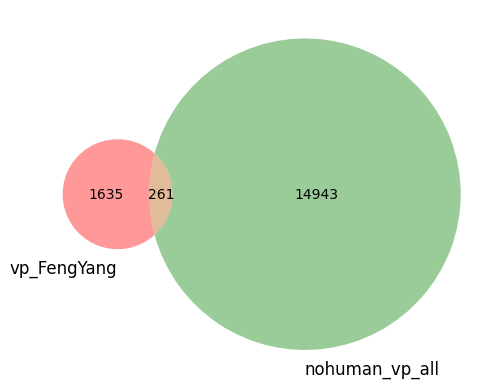

In [40]:
## FengYang提供的所有人类病毒蛋白组数据，根据该数据，将vhppipred的所有宿主为非人哺乳动物的病毒蛋白在病毒种水平上进行去除，剩下的病毒蛋白用于构建vhppipred的负样本。

## FengYang数据集中所有人类病毒
dt_allhumanvirus_fengyang = pd.read_excel("../original_dataset/all_humanvirus_fengyang.xlsx", sheet_name="Sheet1", header=0)
virusspeciesname_fengyang = set(dt_allhumanvirus_fengyang["Species"])

## 所有宿主为非人哺乳动物的病毒蛋白对应的病毒物种
dict_nohumanvirus_species_prot = defaultdict(list)
for record in SeqIO.parse("../original_dataset/virushostdb.formatted.cds.faa", "fasta"):
    virusspecies, virusprot = " ".join(str(record.description).split("|")[0].split()[1:]), str(record.id)
    dict_nohumanvirus_species_prot[virusspecies].append(virusprot)
virusspeciesname_nohuman = set(dict_nohumanvirus_species_prot.keys())

## 二者在病毒种水平上的交集情况
venn2(subsets = (len(set(virusspeciesname_fengyang)), len(set(virusspeciesname_nohuman)), len(set(virusspeciesname_fengyang) & set(virusspeciesname_nohuman))), set_labels=("vp_FengYang", "nohuman_vp_all"))
plt.show()

In [41]:
## 去掉vp_FengYang和nohuman_vp_all中重叠的病毒物种（261）后，剩下的宿主为非人哺乳动物病毒蛋白用于构建负样本
except_virus_id = []
for vspecies, vprotlist in dict_nohumanvirus_species_prot.items():
    if vspecies in virusspeciesname_fengyang:
        except_virus_id += vprotlist

print(len(set(except_virus_id)))

7984


In [42]:
## 负样本病毒蛋白和人类蛋白

dt_virus_nohvirus_cluster = pd.read_csv("../original_dataset/virus_prots_nohuman_virus_protsRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dt_nohvirus_cluster = pd.DataFrame(data=None, columns=["cluster", "representative"])
for _,gp in dt_virus_nohvirus_cluster.groupby(by=["cluster"]):
    gp.reset_index(drop=True, inplace=True)
    if (len(set(gp["representative"]) & set(dt_virus_cluster["representative"]))==0) and (len(set(gp["representative"]) & set(except_virus_id))==0):
        dt_nohvirus_cluster = pd.concat([dt_nohvirus_cluster, gp], ignore_index=True)
virus_neg_cluster_list = list(set(dt_nohvirus_cluster["cluster"]))
print(len(virus_neg_cluster_list)) ## 负样本病毒蛋白簇


dt_human_pos_cluster = pd.read_csv("../original_dataset/human_prots_posRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dt_human_pos_neg_cluster = pd.read_csv("../original_dataset/human_prots_neg_posRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dt_human_neg_cluster = pd.DataFrame(data=None, columns=["cluster","representative"])
for _,gp in dt_human_pos_neg_cluster.groupby(by=["cluster"]):
    gp.reset_index(drop=True, inplace=True)
    if len(set(gp["representative"]) & set(dt_human_pos_cluster["representative"]))==0:
        dt_human_neg_cluster = pd.concat([dt_human_neg_cluster, gp], ignore_index=True)
human_neg_cluster_list = list(set(dt_human_neg_cluster["cluster"]))
print(len(human_neg_cluster_list)) ## 负样本人类蛋白

1818
4087


In [43]:
## 负样本构建方法 (-)

random.seed(3)

## 1818/6 = 303
virus_neg_cluster_list = random.sample(virus_neg_cluster_list, len(virus_neg_cluster_list)) ## 负样本人类蛋白簇
vnclu1 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[0:303])].reset_index(drop=True)
vnclu2 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[303:303*2])].reset_index(drop=True)
vnclu3 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[303*2:303*3])].reset_index(drop=True)
vnclu4 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[303*3:303*4])].reset_index(drop=True)
vnclu5 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[303*4:303*5])].reset_index(drop=True)
vnclu6 = dt_nohvirus_cluster[dt_nohvirus_cluster["cluster"].isin(virus_neg_cluster_list[303*5:])].reset_index(drop=True)


human_neg_cluster_list = random.sample(human_neg_cluster_list, len(human_neg_cluster_list))  ## 负样本人类蛋白簇
hnclu1 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[0:681])].reset_index(drop=True)
hnclu2 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[681:681*2])].reset_index(drop=True)
hnclu3 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[681*2:681*3])].reset_index(drop=True)
hnclu4 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[681*3:681*4])].reset_index(drop=True)
hnclu5 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[681*4:681*5])].reset_index(drop=True)
hnclu6 = dt_human_neg_cluster[dt_human_neg_cluster["cluster"].isin(human_neg_cluster_list[681*5:])].reset_index(drop=True)

## 负样本病毒蛋白簇和人类蛋白簇进行随机组合
vngp1 = pd.DataFrame(list(product(list(vnclu1["representative"]), list(hnclu1["representative"]))), columns=["virus_unid", "human_unid"])
vngp2 = pd.DataFrame(list(product(list(vnclu2["representative"]), list(hnclu2["representative"]))), columns=["virus_unid", "human_unid"])
vngp3 = pd.DataFrame(list(product(list(vnclu3["representative"]), list(hnclu3["representative"]))), columns=["virus_unid", "human_unid"])
vngp4 = pd.DataFrame(list(product(list(vnclu4["representative"]), list(hnclu4["representative"]))), columns=["virus_unid", "human_unid"])
vngp5 = pd.DataFrame(list(product(list(vnclu5["representative"]), list(hnclu5["representative"]))), columns=["virus_unid", "human_unid"])
vngp6 = pd.DataFrame(list(product(list(vnclu6["representative"]), list(hnclu6["representative"]))), columns=["virus_unid", "human_unid"])

print(vngp1.shape)
print(vngp2.shape)
print(vngp3.shape)
print(vngp4.shape)
print(vngp5.shape)
print(vngp6.shape)



def vngpSampling(vngpN, vngpNRest, minPosCount, group, fold=10): ## fold: pos:neg=1:10
    if vngpN.shape[0] == minPosCount*fold:
        vngpN_new = vngpN.loc[:, ['virus_unid', 'human_unid']]
        vngpN_new["group"] = [group,]*len(vngpN_new)
        vngpN_new["label"] = [0.0,]*len(vngpN_new)
    else:
        vngpN["human_cluster"] = [dict_human_cluster[vngpN["human_unid"][i]] for i in range(vngpN.shape[0])]
        vngpNRest["human_cluster"] = [dict_human_cluster[vngpNRest["human_unid"][i]] for i in range(vngpNRest.shape[0])]
        vngpN_new = []
        vngpN_vhppi_list = [vngpN["virus_unid"][i]+"-"+vngpN["human_unid"][i]+"-"+vngpN["human_cluster"][i] for i in range(vngpN.shape[0])]
        vngpN_virus_list = list([x.split("-")[0] for x in vngpN_vhppi_list])
        vngpN_vhppi_cluster, vngpNRest_vhppi_cluster = list(set(vngpN["human_cluster"])), list(set(vngpNRest["human_cluster"]))

        ## Top1
        vngpN_vhppi_target_cluster_top1 = list(set(vngpN_vhppi_cluster)-set(vngpNRest_vhppi_cluster)) ## vngpN的human clusters 不在 vngpNRest的human clusters中 (采样优先选这种)
        #print(len(vngpN_vhppi_target_cluster_top1))

        temp_intersection = list(set(vngpN_vhppi_cluster) & set(vngpNRest_vhppi_cluster))
        dt_temp_cluster_count, temp_element = [], [x for x in temp_intersection if x in vngpNRest_vhppi_cluster]
        for cluster, count in Counter(temp_element).items():
            dt_temp_cluster_count.append([cluster, count])
        dt_temp_cluster_count = pd.DataFrame(dt_temp_cluster_count, columns=["cluster","count"])
        dt_temp_cluster_count.sort_values(by=["count"], ascending=True, ignore_index=True, inplace=True)
        ## Top2
        vngpN_vhppi_target_cluster_top2 = list(dt_temp_cluster_count["cluster"])
        #print(len(vngpN_vhppi_target_cluster_top2))
        
        while len(vngpN_new) < minPosCount*10:
            vngpN_virus_set = list(set(vngpN_virus_list))
            for vid in vngpN_virus_set:
                for vhppi in vngpN_vhppi_list:
                    if vid == vhppi.split("-")[0]:
                        if vhppi.split("-")[2] in vngpN_vhppi_target_cluster_top1:
                            vngpN_new.append("-".join(vhppi.split("-")[0:2]))
                            break
                        elif vhppi.split("-")[2] in vngpN_vhppi_target_cluster_top2:
                            vngpN_new.append("-".join(vhppi.split("-")[0:2]))
                            break
                        #else:
                            #print(vhppi)
                        #    break
                if len(vngpN_new)==minPosCount*fold:
                    break
            vngpN_vhppi_list = list(set(vngpN_vhppi_list) - set(vngpN_new))
            vngpN_virus_list = list([x.split("-")[0] for x in vngpN_vhppi_list])
        vngpN_new = [[x.split("-")[0],x.split("-")[1]] for x in vngpN_new]
        vngpN_new = pd.DataFrame(vngpN_new, columns=["virus_unid","human_unid"])
        vngpN_new["group"] = [group,]*len(vngpN_new)
        vngpN_new["label"] = [0.0,]*len(vngpN_new)

    return vngpN_new



(361030, 2)
(359373, 2)
(432540, 2)
(393624, 2)
(464056, 2)
(384030, 2)


In [44]:
## 调用负样本构建方法

vngpN_1, vngpNRest_1 = vngp1, pd.concat([vngp2, vngp3, vngp4, vngp5, vngp6], ignore_index=True)
vngpN_2, vngpNRest_2 = vngp2, pd.concat([vngp1, vngp3, vngp4, vngp5, vngp6], ignore_index=True)
vngpN_3, vngpNRest_3 = vngp3, pd.concat([vngp1, vngp2, vngp4, vngp5, vngp6], ignore_index=True)
vngpN_4, vngpNRest_4 = vngp4, pd.concat([vngp1, vngp2, vngp3, vngp5, vngp6], ignore_index=True)
vngpN_5, vngpNRest_5 = vngp5, pd.concat([vngp1, vngp2, vngp3, vngp4, vngp6], ignore_index=True)
vngpN_6, vngpNRest_6 = vngp6, pd.concat([vngp1, vngp2, vngp3, vngp4, vngp5], ignore_index=True)

vngp1_new = vngpSampling(vngpN=vngpN_1, vngpNRest=vngpNRest_1, minPosCount=minPosCount, group="gp_1", fold=10)
vngp2_new = vngpSampling(vngpN=vngpN_2, vngpNRest=vngpNRest_2, minPosCount=minPosCount, group="gp_2", fold=10)
vngp3_new = vngpSampling(vngpN=vngpN_3, vngpNRest=vngpNRest_3, minPosCount=minPosCount, group="gp_3", fold=10)
vngp4_new = vngpSampling(vngpN=vngpN_4, vngpNRest=vngpNRest_4, minPosCount=minPosCount, group="gp_4", fold=10)
vngp5_new = vngpSampling(vngpN=vngpN_5, vngpNRest=vngpNRest_5, minPosCount=minPosCount, group="gp_5", fold=10)
vngp6_new = vngpSampling(vngpN=vngpN_6, vngpNRest=vngpNRest_6, minPosCount=minPosCount, group="gp_6", fold=10)
        
print(vngp1_new.shape)
print(vngp2_new.shape)
print(vngp3_new.shape)
print(vngp4_new.shape)
print(vngp5_new.shape)
print(vngp6_new.shape)

(11930, 4)
(11930, 4)
(11930, 4)
(11930, 4)
(11930, 4)
(11930, 4)


In [46]:
## 正负样本合并
dt_res = pd.concat([vpgp1_new, vngp1_new, 
                    vpgp2_new, vngp2_new,
                    vpgp3_new, vngp3_new,
                    vpgp4_new, vngp4_new,
                    vpgp5_new, vngp5_new,
                    vpgp6_new, vngp6_new], ignore_index=True)


dt_res.to_csv("../dataset/data_fold10.csv", sep="\t", index=False) ## 不同fold之间的病毒蛋白没有相似性，但是人类蛋白可能存在相似性。
dt_human_pos_neg_cluster = pd.read_csv("../original_dataset/human_prots_neg_posRes_cluster.tsv", sep="\t", names=["cluster","representative"])
dict_human_cluster = {dt_human_pos_neg_cluster["representative"][i]:dt_human_pos_neg_cluster["cluster"][i] for i in range(dt_human_pos_neg_cluster.shape[0])}
dt_res["human_cluster"] = [dict_human_cluster[h] for h in dt_res["human_unid"]]
dt_res.to_csv("../dataset/data_fold10_info.csv", sep="\t", index=False)

3980
938
3042
3872
1625
2247


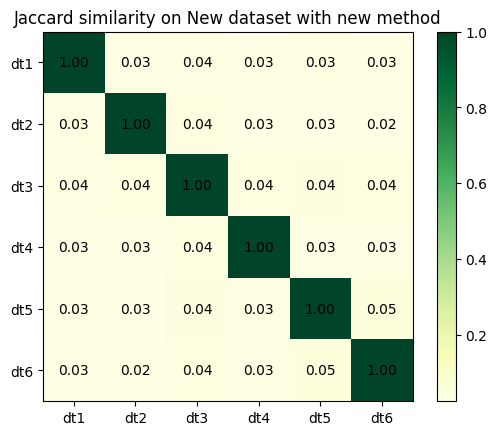

In [49]:
## 可视化子集之间人类蛋白簇的相似度

dt_dataset_fold10 = dt_res
dt_dataset_fold10_pos = dt_dataset_fold10[dt_dataset_fold10["label"]==1.0].reset_index(drop=True)
dt_dataset_fold10_neg = dt_dataset_fold10[dt_dataset_fold10["label"]==0.0].reset_index(drop=True)

print(len(set(dt_dataset_fold10["virus_unid"])))
print(len(set(dt_dataset_fold10_pos["virus_unid"])))
print(len(set(dt_dataset_fold10_neg["virus_unid"])))

print(len(set(dt_dataset_fold10["human_unid"])))
print(len(set(dt_dataset_fold10_pos["human_unid"])))
print(len(set(dt_dataset_fold10_neg["human_unid"])))


##-----------------
overlapMatrix = np.zeros((6,6))
for i in range(1,7):
    dt_i = dt_dataset_fold10[dt_dataset_fold10["group"]=="gp_"+str(i)].reset_index(drop=True)
    set_i_hp = set(dt_i["human_cluster"])
    for j in range(1,7):
        dt_j = dt_dataset_fold10[dt_dataset_fold10["group"]=="gp_"+str(j)].reset_index(drop=True)
        set_j_hp = set(dt_j["human_cluster"])
        ## 计算杰卡德距离 = 1-杰卡德相似性 (距离越大与不相似，越小越相似)
        jaccard_similarity = len(set_i_hp & set_j_hp)/len(set_i_hp | set_j_hp)
        overlapMatrix[i-1, j-1] = jaccard_similarity

xLabel = ["dt1", "dt2", "dt3", "dt4", "dt5", "dt6"]
yLabel = ["dt1", "dt2", "dt3", "dt4", "dt5", "dt6"]

#fig = plt.figure()
#ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)

im = ax.imshow(overlapMatrix, cmap="YlGn")
for i in range(len(yLabel)):
    for j in range(len(xLabel)):
        ax.text(j, i, '{:.2f}'.format(overlapMatrix[i, j]), ha="center", va="center", color="black")
plt.colorbar(im)
plt.title("Jaccard similarity on New dataset with new method")
plt.show()


## 1.3 Component of benchmark dataset

In [52]:
dt_dataset = pd.read_csv("../dataset/data_fold10.csv", sep="\t", header=0)
print("%s\t%s\t%s" % ("Subset","Positive","Negative"))
for dt_n, gp in dt_dataset.groupby(by="group"):
    gp.reset_index(drop=True, inplace=True)
    gp_pos = gp[gp["label"]==1.0].reset_index(drop=True)
    gp_neg = gp[gp["label"]==0.0].reset_index(drop=True)
    print("%s\t%s\t%s" % (dt_n, gp_pos.shape[0], gp_neg.shape[0]))

dt_dataset_pos = dt_dataset[dt_dataset["label"]==1.0].reset_index(drop=True)
dt_dataset_neg = dt_dataset[dt_dataset["label"]==0.0].reset_index(drop=True)
print("%s\t%s\t%s" % ("SUM",dt_dataset_pos.shape[0], dt_dataset_neg.shape[0]))

print("包含 {} 个病毒蛋白 ({}pos + {}neg) 和 {} 个人类蛋白 ({}pos + {}neg)".format(len(set(dt_dataset["virus_unid"])), len(set(dt_dataset_pos["virus_unid"])), len(set(dt_dataset_neg["virus_unid"])),\
                                                                     len(set(dt_dataset["human_unid"])), len(set(dt_dataset_pos["human_unid"])), len(set(dt_dataset_neg["human_unid"]))))

Subset	Positive	Negative
gp_1	1193	11930
gp_2	1193	11930
gp_3	1193	11930
gp_4	1193	11930
gp_5	1193	11930
gp_6	1193	11930
SUM	7158	71580
包含 3980 个病毒蛋白 (938pos + 3042neg) 和 3872 个人类蛋白 (1625pos + 2247neg)


# 2. Removing overlapped PPIs between benchmark dataset and Yang's Dataset, Zhou's Dataset and DeNovo Dataset:

In [1]:
# 导入模块
import pandas as pd

In [2]:
ppi_vhppipred_dataset_fold10 = []

dt_vhppipred_fold10 = pd.read_csv("../../dataset/data_fold10.csv", sep="\t", header=0)
for i in range(dt_vhppipred_fold10.shape[0]):
    ppi_vhppipred_dataset_fold10.append(dt_vhppipred_fold10["virus_unid"][i]+"-"+dt_vhppipred_fold10["human_unid"][i])

print(len(set(ppi_vhppipred_dataset_fold10)))

8432


## 2.1 Yang's dataset

In [4]:
dt_yangdeepviral = pd.read_csv("../../YangDeepViralDatasetEmbed/data_yangdeepviral.csv", sep="\t", header=0)
dt_yangdeepviral_fold10_nr = []
for i in range(dt_yangdeepviral.shape[0]):
    if dt_yangdeepviral["virus_unid"][i]+"-"+dt_yangdeepviral["human_unid"][i] not in set(ppi_vhppipred_dataset_fold10):
        dt_yangdeepviral_fold10_nr.append([dt_yangdeepviral["virus_unid"][i], dt_yangdeepviral["human_unid"][i], dt_yangdeepviral["label"][i]])
        
dt_yangdeepviral_fold10_nr = pd.DataFrame(dt_yangdeepviral_fold10_nr, columns=["virus_unid", "human_unid", "label"])
dt_yangdeepviral_fold10_nr.to_csv("../../YangDeepViralDatasetEmbed/data_yangdeepviral_fold10_nr.csv", sep="\t", index=False)

print("Before:{}\nFold10_nr:{}".format(dt_yangdeepviral.shape, dt_yangdeepviral_fold10_nr.shape))

Before:(13651, 3)
Fold10_nr:(13403, 3)


## 2.2 Zhou's dataset

In [3]:
#dt_zhou = pd.read_csv("../../ZhouDatasetEmbed/data_zhou.csv", sep="\t", header=0)
dt_zhou = pd.read_csv("../../../ZhouDatasetEmbed_new/data_zhou_ppi_new.csv", sep="\t", header=0)
dt_zhou_fold10_nr = []
for i in range(dt_zhou.shape[0]):
    if dt_zhou["virus_unid"][i]+"-"+dt_zhou["human_unid"][i] not in set(ppi_vhppipred_dataset_fold10):
        dt_zhou_fold10_nr.append([dt_zhou["virus_unid"][i], dt_zhou["human_unid"][i], dt_zhou["label"][i]])

dt_zhou_fold10_nr = pd.DataFrame(dt_zhou_fold10_nr, columns=["virus_unid", "human_unid", "label"])
dt_zhou_fold10_nr.to_csv("../../../ZhouDatasetEmbed_new/data_zhou_new_fold10_nr.csv", sep="\t", index=False)

print("Before:{}\nFold10_nr:{}".format(dt_zhou.shape, dt_zhou_fold10_nr.shape))

Before:(749, 3)
Fold10_nr:(748, 3)


## 2.3 DeNovo dataset

In [6]:
dt_denovo = pd.read_csv("../../DeNovoDatasetEmbed/data_denovo.csv", sep="\t", header=0)
dt_denovo_fold10_nr = []
for i in range(dt_denovo.shape[0]):
    if dt_denovo["virus_unid"][i]+"-"+dt_denovo["human_unid"][i] not in set(ppi_vhppipred_dataset_fold10):
        dt_denovo_fold10_nr.append([dt_denovo["virus_unid"][i], dt_denovo["human_unid"][i], dt_denovo["label"][i]])

dt_denovo_fold10_nr = pd.DataFrame(dt_denovo_fold10_nr, columns=["virus_unid", "human_unid", "label"])
dt_denovo_fold10_nr.to_csv("../../DeNovoDatasetEmbed/data_denovo_fold10_nr.csv", sep="\t", index=False)

print("Before:{}\nFold10_nr:{}".format(dt_denovo.shape, dt_denovo_fold10_nr.shape))

Before:(5151, 3)
Fold10_nr:(4800, 3)
